100.0%

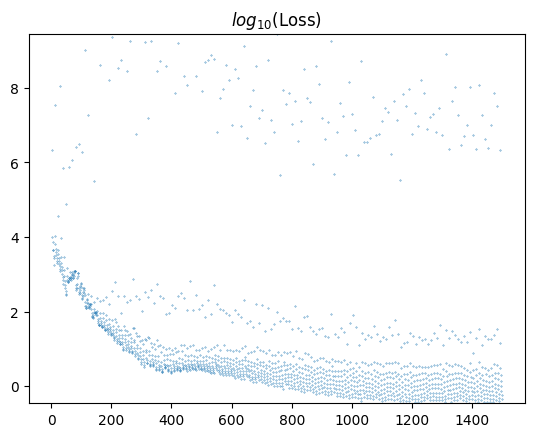

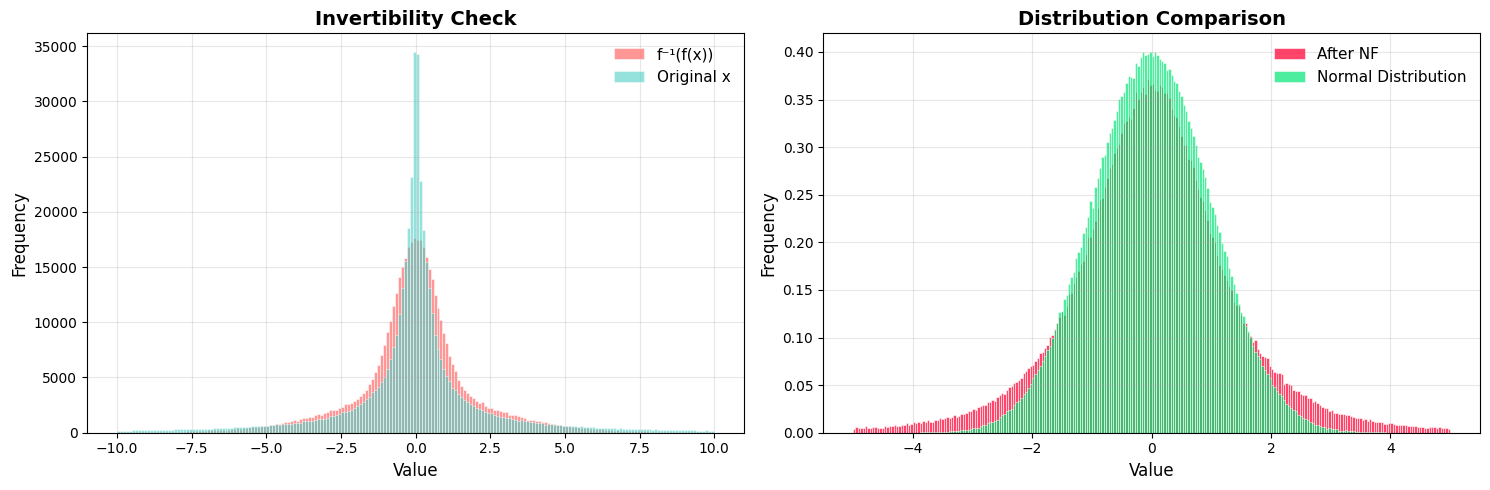

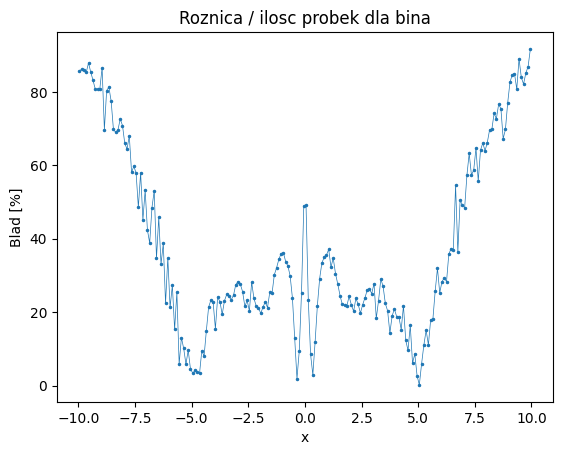

100.0%

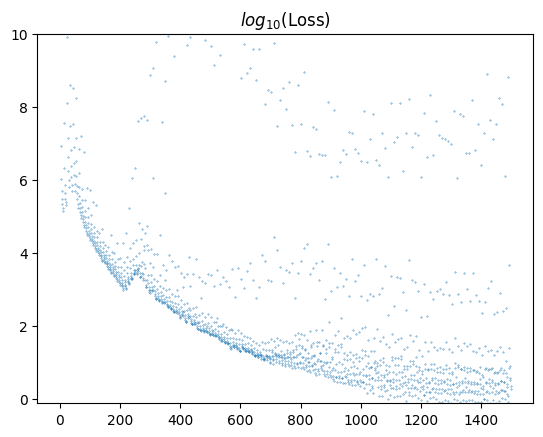

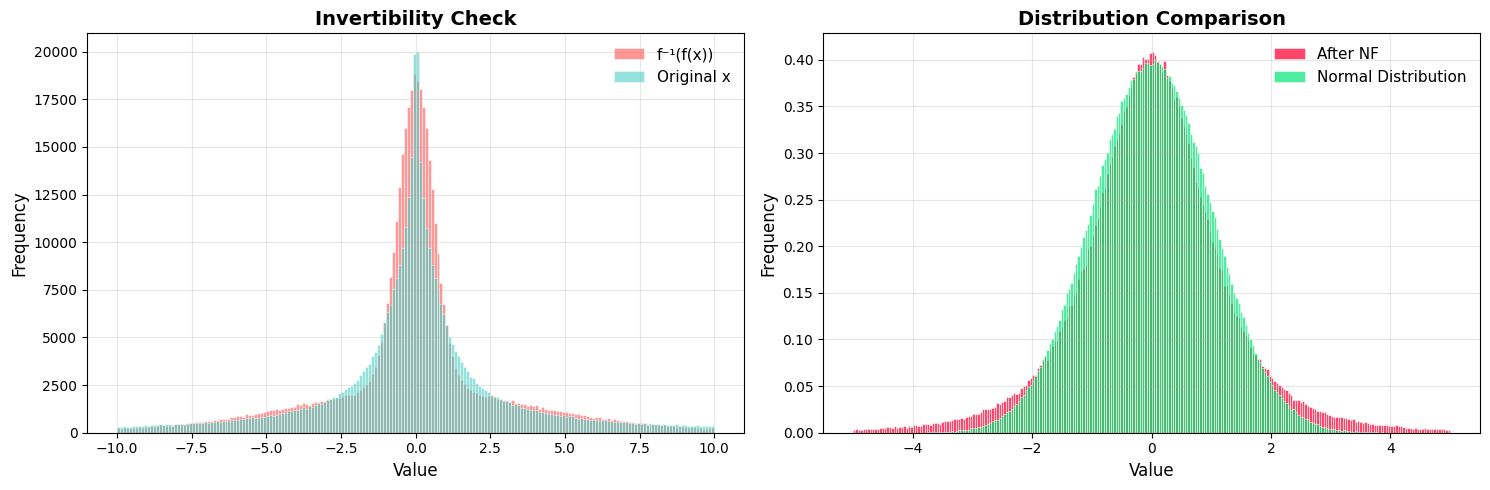

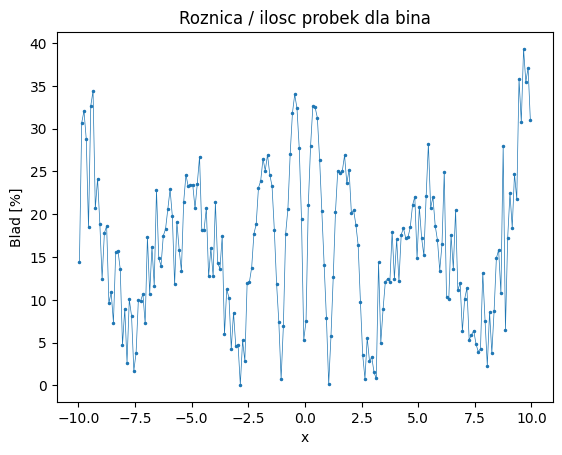

In [68]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sys
import numpy as np
from walidacja_funkcji import *

sys.path.append('/home/mamusiaarusia/myenv/lib/python3.12/site-packages/torch')

prober = rs_prober_NKG(epsilon=0.1, looking_x_left=-1, looking_x_right=1, from_x=0)

def get_2d_data(PROBE_SIZE: int, phi: int):
    rs = prober.rejection_sampling(length=PROBE_SIZE // 2)
    theta = np.random.uniform(0, 2*np.pi, PROBE_SIZE // 2)
    xs = rs * np.cos(theta) * np.cos(phi)
    ys = rs * np.sin(theta)
    return np.vstack([xs, ys]).T


class MinMaxModule(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return (x - x.min()) / (x.max() - x.min())


class NF_layer(nn.Module):
    def __init__(self, translate_layers: list[nn.Module], scale_layers: list[nn.Module], lr):
        super().__init__()
        self.translate = nn.Sequential(*translate_layers)
        self.scale = nn.Sequential(*scale_layers)
        self.optim = torch.optim.RMSprop(self.parameters(), lr=lr) # tu nie jestem pewny moze dwa oddzielne optimizery powinny isc idk

        self.to('cuda')

    # mozna dodac loss_backward z funkcja probkowania z NKG
    def loss(self, output: torch.Tensor, log_diag: torch.Tensor = None):
        return 0.5 * (output ** 2).mean() - log_diag.mean() # No czekaj ale do czego to tak naprawde zmierza

    def loss_and_step(self, output: torch.Tensor, log_diag: torch.Tensor = None):
        self.zero_grad()
        loss = self.loss(output, log_diag)
        loss.backward()
        self.optim.step()
        return loss.item()

    def calculate_forward(self, input: torch.Tensor, function: callable) -> torch.Tensor:
        div_indx = input.shape[-1] // 2
        x1 = input[:, :div_indx]
        x2 = input[:, div_indx:]

        scaled = self.scale(x1)
        translated = self.translate(x1)
        diag_sum = scaled # we wzorze jest dzielenie przez N, czyli srednia troche nawet zawyza wynik, ale to chyba dobrze
        x1 = function(x2, scaled, translated)
        z = torch.cat([x2, x1], dim=-1) # swap

        return z, diag_sum, x1

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.calculate_forward(input, lambda x2, scaled, translated: (x2 + translated) * torch.exp(scaled))

    def inverse(self, input: torch.Tensor) -> torch.Tensor:
        return self.calculate_forward(input, lambda x2, scaled, translated: x2 / torch.exp(scaled) - translated)


class NF(nn.Module):
    def __init__(self, num_layers: int, input_size: int, lr: float):
        super().__init__()

        def scaling_components():
            return [
                nn.Linear(input_size, input_size), nn.Softsign(),
                nn.Linear(input_size, input_size), 
                nn.Linear(input_size, input_size), 
                nn.Linear(input_size, input_size), 
                nn.Linear(input_size, input_size), 
            ]

        def translating_components():
            return [
                nn.Linear(input_size, input_size), 
                nn.Linear(input_size, input_size), 
            ]

        self.layers = nn.ModuleList([NF_layer(translating_components(), scaling_components(), lr) for _ in range(num_layers)])
        self.to('cuda')

    def forward(self, x):
        return self.iterate_layers(x, forward=True, learn=False)

    def inverse(self, x):
        return self.iterate_layers(x, forward=False, learn=False)

    def loss_and_step(self, x):
        return self.iterate_layers(x, forward=True, learn=True)

    def iterate_layers(self, input: torch.Tensor, forward: bool, learn: bool):
        output = input.clone()
        transformed = None
        losses = 0

        iter_layers = self.layers if forward else reversed(self.layers)
        for layer in iter_layers:
            if forward:
                output, diag_sum, transformed = layer.forward(output)
            else:
                output, diag_sum, transformed = layer.inverse(output)

            if learn:
                losses += layer.loss_and_step(transformed, diag_sum)
                output = output.detach()

        if learn:
            return losses

        return output


def learn_nf(nf_model: nn.Module, GENERATOR_SAMPLES_TO_RETURN: int, BATCH_SIZE: int, EPOCHS: int, zenith_angle: float, dim: int = 0):
    PROBE_SIZE = GENERATOR_SAMPLES_TO_RETURN * BATCH_SIZE
    values = get_2d_data(PROBE_SIZE, zenith_angle).reshape(BATCH_SIZE, -1, 2)
    x = torch.Tensor(values[:, :, dim]).cuda()
    loss_history = np.empty(EPOCHS)

    nf_model.train()
    for epoch in range(EPOCHS):
        print(f'\r{epoch / (EPOCHS - 1) * 100:.1f}%', end='', flush=True)
        loss_history[epoch] = nf_model.loss_and_step(x)
        if epoch % 10 == 0:
            values = get_2d_data(PROBE_SIZE, zenith_angle).reshape(BATCH_SIZE, -1, 2)
            x = torch.Tensor(values[:, :, dim]).cuda()

    nf_model.eval()

    plt.plot(loss_history, 'o', markersize=0.3)
    plt.ylim([np.min(loss_history[500:]), min(np.max(loss_history[500:]), 10)])
    plt.title(r'$log_{10}$(Loss)')
    plt.show()

    temp = get_2d_data(PROBE_SIZE * 10, zenith_angle).reshape(BATCH_SIZE * 10, -1, 2)
    x = torch.Tensor(temp[:, :, dim]).cuda()
    theory = np.random.randn(PROBE_SIZE * 10)
    to_inverse = torch.Tensor(theory).reshape(BATCH_SIZE * 10, GENERATOR_SAMPLES_TO_RETURN // 2, 2).cuda()[:, :, dim]

    values = nf_model.forward(x)
    inversed = nf_model.inverse(to_inverse).detach().flatten().cpu().numpy()
    values = values.detach().flatten().cpu().numpy()

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    colors = ['#FF6B6B', '#4ECDC4']
    
    inversed_bins, edges, _ = ax1.hist(inversed, bins=200, range=[-10, 10], label='f⁻¹(f(x))', 
            color=colors[0], alpha=0.7, edgecolor='white', linewidth=0.5)
    theory_bins, _, _ = ax1.hist(x.detach().flatten().cpu().numpy(), bins=200, range=[-10, 10], label='Original x',
            color=colors[1], alpha=0.6, edgecolor='white', linewidth=0.5)
    ax1.set_title('Invertibility Check', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Value', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.legend(frameon=False, fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    ax2.hist(values, bins=250, range=[-5, 5], label='After NF',
            color='#FF1744', alpha=0.8, edgecolor='white', linewidth=0.5, density=True)
    ax2.hist(theory, bins=250, range=[-5, 5], label='Normal Distribution',
            color='#00E676', alpha=0.7, edgecolor='white', linewidth=0.5, density=True)
    ax2.set_title('Distribution Comparison', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Value', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.legend(frameon=False, fontsize=11)
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    avg_edges = (edges[1:] + edges[:-1]) / 2
    plt.title('Roznica / ilosc probek dla bina')
    plt.plot(avg_edges, np.clip(np.abs(inversed_bins - theory_bins) / (np.maximum(inversed_bins, theory_bins)) * 100, 0, 100), '-o', markersize=1.5, linewidth=0.5)
    plt.xlabel('x')
    plt.ylabel('Blad [%]')
    plt.show()


GENERATOR_SAMPLES_TO_RETURN = 768
DIMS = GENERATOR_SAMPLES_TO_RETURN // 4
BATCH_SIZE = 128
EPOCHS = 1_500
LR = 5e-4

zenith_angle = np.pi / 3

x_model = NF(6, DIMS, LR)
x_loss = learn_nf(x_model, GENERATOR_SAMPLES_TO_RETURN, BATCH_SIZE, EPOCHS, zenith_angle, 0)

y_model = NF(6, DIMS, LR)
y_loss = learn_nf(y_model, GENERATOR_SAMPLES_TO_RETURN, BATCH_SIZE, EPOCHS, zenith_angle, 1)

Text(0, 0.5, 'y')

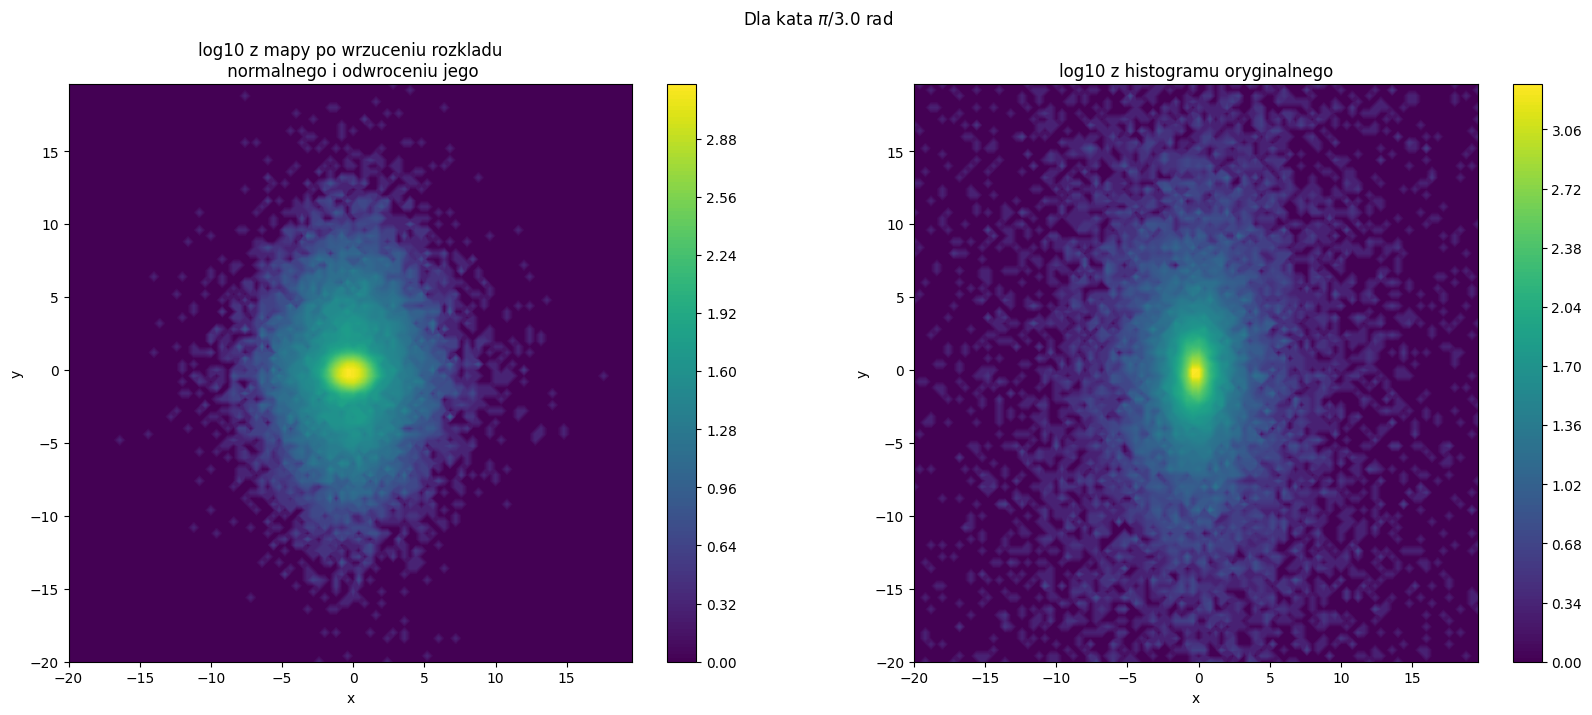

In [67]:
PROBE_SIZE = GENERATOR_SAMPLES_TO_RETURN * BATCH_SIZE
normal_dist = torch.randn(size=(BATCH_SIZE, GENERATOR_SAMPLES_TO_RETURN // 2, 2)).cuda()

x_normal_dist, y_normal_dist = normal_dist[:, :, 0], normal_dist[:, :, 1]

x_nkg = x_model.inverse(x_normal_dist).detach().cpu().numpy().reshape(-1)
y_nkg = y_model.inverse(y_normal_dist).detach().cpu().numpy().reshape(-1)

theory = get_2d_data(PROBE_SIZE, zenith_angle)
x_theory, y_theory = theory[:, 0], theory[:, 1]
original_hist, x_edges_orig, y_edges_orig = np.histogram2d(x_theory, y_theory, bins=100, range=[[-20, 20], [-20, 20]])

hist, x_edges, y_edges = np.histogram2d(x_nkg, y_nkg, bins=100, range=[[x_edges_orig[0], x_edges_orig[-1]], [y_edges_orig[0], y_edges_orig[-1]]])
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 7.5))
plt.suptitle(rf'Dla kata $\pi / {(np.pi / zenith_angle):.1f}$ rad')

ax1.set_title('log10 z mapy po wrzuceniu rozkladu\n normalnego i odwroceniu jego')
contour1 = ax1.contourf(x_edges[:-1], y_edges[:-1], np.log10(hist.T + 1), levels=200)
plt.colorbar(contour1, ax=ax1)
ax1.set_xlabel('x')
ax1.set_ylabel('y')


ax2.set_title('log10 z histogramu oryginalnego')
contour2 = ax2.contourf(x_edges_orig[:-1], y_edges_orig[:-1], np.log10(original_hist.T + 1), levels=200)
plt.colorbar(contour2, ax=ax2)
ax2.set_xlabel('x')
ax2.set_ylabel('y')

(101,)

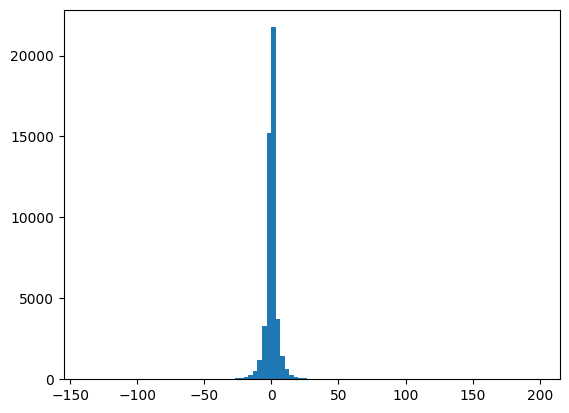

In [ ]:
PROBE_SIZE = GENERATOR_SAMPLES_TO_RETURN * BATCH_SIZE
values = get_2d_data(PROBE_SIZE, zenith_angle).reshape(BATCH_SIZE, -1, 2)
x = torch.Tensor(values[:, :, 0]).cuda()
x_inv = x_model.inverse(x_model.forward(x)).flatten().detach().cpu().numpy()

a, b, c = plt.hist(x_inv, bins=100)